In [5]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim

import open3d as o3d
from open3d.ml.torch.layers import SparseConv

import numpy as np
import matplotlib.pyplot as plt

# Loading Data

In [6]:
data = np.load("data.npy")
data.shape

(111620, 7)

# Visualizing Data

In [7]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data[:, :3])
pcd.colors = o3d.utility.Vector3dVector(data[:,3:6]/255)

In [8]:
o3d.visualization.draw_geometries([pcd])


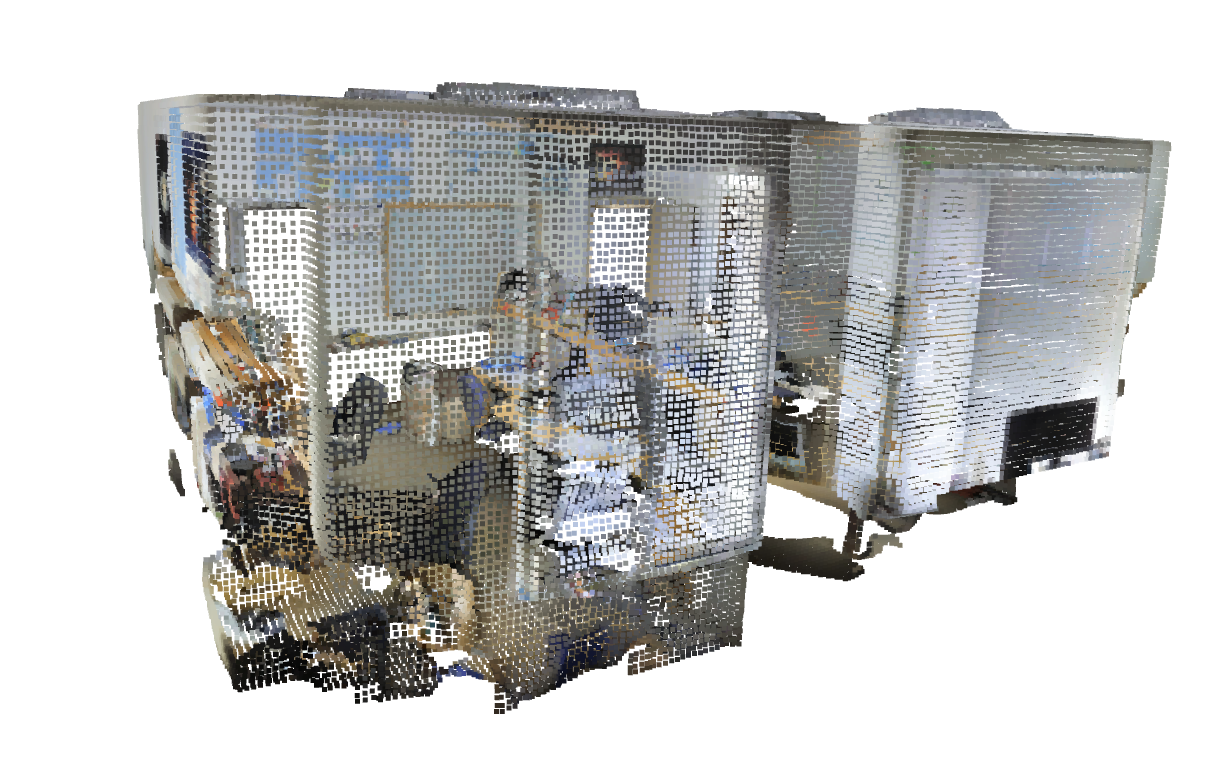

In [9]:
coords = data[:, :3]
features = data[:,3:6]/255
labels = data[:, 6:]

In [10]:
coords.shape, features.shape, labels.shape

((111620, 3), (111620, 3), (111620, 1))

In [11]:
coords = torch.from_numpy(coords.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
labels = torch.from_numpy(labels.astype(np.float64))

# Hash Function
Creating a dictionary to save active output site for corresponding active input site

In [12]:
def calculate_grid(in_positions):
    filter = torch.Tensor([[-1, -1, -1], [-1, -1, 0], [-1, 0, -1], [-1, 0, 0],
                           [0, -1, -1], [0, -1, 0], [0, 0, -1],
                           [0, 0, 0]])
    
    out_pos = torch.Tensor(in_positions).repeat(1, filter.shape[0]).reshape(-1, 3)
    filter = filter.repeat(in_positions.shape[0], 1)

    out_pos = out_pos + filter
#     out_pos = out_pos[out_pos.min(1).values >= 0]
    out_pos = out_pos[(~((out_pos.long() % 2).bool()).any(1))]
    out_pos = torch.unique(out_pos, dim=0)

    return out_pos + 0.5

In [13]:
positions = {f"conv{i}":{} for i in range(1,4)}
positions["conv1"]["in"] = coords
positions["conv1"]["out"] = calculate_grid(coords)
for i in range(2,4):
    positions[f"conv{i}"]["in"] = positions[f"conv{i-1}"]["out"]
    positions[f"conv{i}"]["out"] = calculate_grid(positions[f"conv{i}"]["in"])

# Creating Model

In [14]:
class Encoder(nn.Module):
    def __init__(self, positions:dict):
        super(Encoder, self).__init__()
        self.conv1 = SparseConv(3, 6, [3,3,3], nn.ReLU(), True, normalize=True)
        self.conv2 = SparseConv(6, 12, [4,4,4], nn.ReLU(), True, normalize=True)
        self.conv3 = SparseConv(12, 32, [3,3,3], nn.ReLU(), True, normalize=True)
        self.pos = positions
    
    def forward(self, x):
        x = self.conv1(x, self.pos["conv1"]["in"], self.pos["conv1"]["out"], voxel_size=0.02)
        x = self.conv2(x, self.pos["conv2"]["in"], self.pos["conv2"]["out"], voxel_size=0.04)
        x = self.conv3(x, self.pos["conv3"]["in"], self.pos["conv3"]["out"], voxel_size=0.08)
        return x

In [15]:
class Decoder(nn.Module):
    def __init__(self, positions:dict):
        super(Decoder, self).__init__()
        self.conv1 = SparseConv(32, 12, [3,3,3], nn.ReLU(), True, normalize=True)
        self.conv2 = SparseConv(12, 6, [4,4,4], nn.ReLU(), True, normalize=True)
        self.conv3 = SparseConv(6, 13, [3,3,3], None, True, normalize=True)
        self.pos = positions
    
    def forward(self, x):
        x = self.conv1(x, self.pos["conv3"]["out"], self.pos["conv3"]["in"], voxel_size=0.08)
        x = self.conv2(x, self.pos["conv2"]["out"], self.pos["conv2"]["in"], voxel_size=0.04)
        x = self.conv3(x, self.pos["conv1"]["out"], self.pos["conv1"]["in"], voxel_size=0.02)
        return x

In [16]:
model = nn.Sequential(OrderedDict([
            ('encoder', Encoder(positions)),
            ('decoder', Decoder(positions))
]))
model

Sequential(
  (encoder): Encoder(
    (conv1): SparseConv(
      (activation): ReLU()
      (fixed_radius_search): FixedRadiusSearch()
    )
    (conv2): SparseConv(
      (activation): ReLU()
      (fixed_radius_search): FixedRadiusSearch()
    )
    (conv3): SparseConv(
      (activation): ReLU()
      (fixed_radius_search): FixedRadiusSearch()
    )
  )
  (decoder): Decoder(
    (conv1): SparseConv(
      (activation): ReLU()
      (fixed_radius_search): FixedRadiusSearch()
    )
    (conv2): SparseConv(
      (activation): ReLU()
      (fixed_radius_search): FixedRadiusSearch()
    )
    (conv3): SparseConv(
      (fixed_radius_search): FixedRadiusSearch()
    )
  )
)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.09)
criterion = nn.CrossEntropyLoss()

In [18]:
epoch_loss = []
EPOCHS = 500
for epoch in range(EPOCHS):
    torch.cuda.empty_cache()
    optimizer.zero_grad()

    preds = model(features)
    loss = criterion(preds, labels.squeeze().long())
    epoch_loss.append(loss.item())

    print(f"Epoch[{epoch+1}, Loss: {loss.item()}]")

    loss.backward()
    optimizer.step()

Epoch[1, Loss: 2.5632126331329346]
Epoch[2, Loss: 2.508779287338257]
Epoch[3, Loss: 2.4628989696502686]
Epoch[4, Loss: 2.418689250946045]
Epoch[5, Loss: 2.3839948177337646]
Epoch[6, Loss: 2.354175090789795]
Epoch[7, Loss: 2.3297111988067627]
Epoch[8, Loss: 2.308603286743164]
Epoch[9, Loss: 2.2891809940338135]
Epoch[10, Loss: 2.277859687805176]
Epoch[11, Loss: 2.2726523876190186]
Epoch[12, Loss: 2.265779495239258]
Epoch[13, Loss: 2.2600724697113037]
Epoch[14, Loss: 2.2543859481811523]
Epoch[15, Loss: 2.2509567737579346]
Epoch[16, Loss: 2.248006820678711]
Epoch[17, Loss: 2.2472457885742188]
Epoch[18, Loss: 2.2452762126922607]
Epoch[19, Loss: 2.244455337524414]
Epoch[20, Loss: 2.2422192096710205]
Epoch[21, Loss: 2.2431418895721436]
Epoch[22, Loss: 2.243236541748047]
Epoch[23, Loss: 2.2398157119750977]
Epoch[24, Loss: 2.239166021347046]
Epoch[25, Loss: 2.2378220558166504]
Epoch[26, Loss: 2.236624240875244]
Epoch[27, Loss: 2.2347240447998047]
Epoch[28, Loss: 2.235029697418213]
Epoch[29, Los

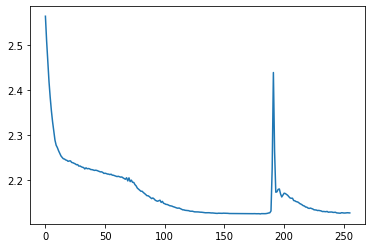

In [164]:
plt.plot(epoch_loss)

In [168]:
print("Accuracy:", sum(preds.argmax(-1) == labels.squeeze()) / preds.shape[0] * 100, "%")

Accuracy: tensor(23.8846) %


In [155]:
# torch.save(model.state_dict(), "model.pth")

# Visualizing Output Map

In [22]:
COLOR_MAP = {
    0: (51., 176., 203.),
    1: (174., 199., 232.),
    2: (152., 223., 138.),
    3: (31., 119., 180.),
    4: (255., 187., 120.),
    5: (188., 189., 34.),
    6: (140., 86., 75.),
    7: (255., 152., 150.),
    8: (214., 39., 40.),
    9: (197., 176., 213.),
    10: (148., 103., 189.),
    11: (196., 156., 148.),
    12: (23., 190., 207.),
#     13: (247., 182., 210.)
}
COLOR_MAP

{0: (51.0, 176.0, 203.0),
 1: (174.0, 199.0, 232.0),
 2: (152.0, 223.0, 138.0),
 3: (31.0, 119.0, 180.0),
 4: (255.0, 187.0, 120.0),
 5: (188.0, 189.0, 34.0),
 6: (140.0, 86.0, 75.0),
 7: (255.0, 152.0, 150.0),
 8: (214.0, 39.0, 40.0),
 9: (197.0, 176.0, 213.0),
 10: (148.0, 103.0, 189.0),
 11: (196.0, 156.0, 148.0),
 12: (23.0, 190.0, 207.0)}

In [23]:
color_map = [np.array(COLOR_MAP[i])/255 for i in range(13)]
color_map = np.array(color_map)

In [24]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(coords.numpy())
pcd.colors = o3d.utility.Vector3dVector(color_map[preds.argmax(-1)])

o3d.visualization.draw_geometries([pcd])

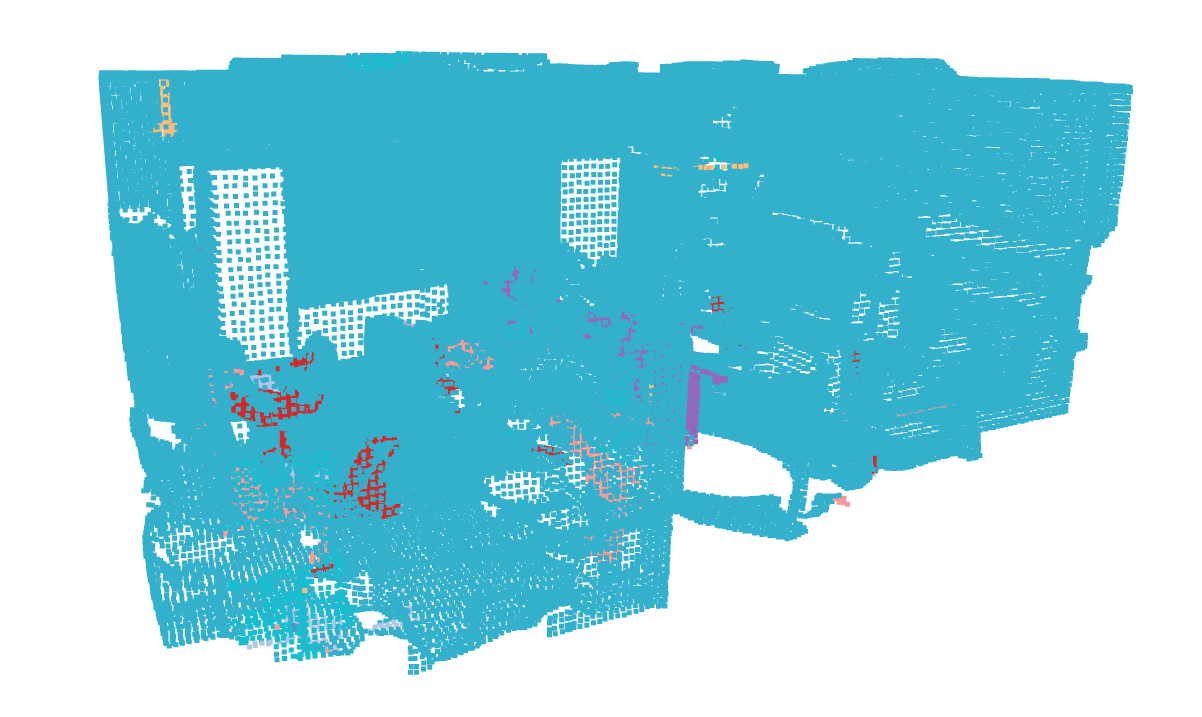